In [35]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import pingouin as pg
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

df = pd.read_csv("1st-dataset-prepressed-total.csv")     # 1차 데이터셋

# df = df[df['sports_type'] == "야구"]        # 야구 데이타만 가져옴

pd.set_option("display.max_columns", None)

df['accident_score'] = df['accident_count'] + 3 * df['injury_count']
df.info()

# 분석용 편의 함수
def pct(n): return f"{n:.1%}"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3395 entries, 0 to 3394
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   game_id         3395 non-null   int64  
 1   stadium_code    3395 non-null   object 
 2   game_date       3395 non-null   object 
 3   day_of_week     3395 non-null   object 
 4   is_holiday      3395 non-null   int64  
 5   start_time      3395 non-null   object 
 6   home_team_win   3395 non-null   int64  
 7   audience        3395 non-null   float64
 8   region          3395 non-null   object 
 9   accident_count  3395 non-null   float64
 10  injury_count    3395 non-null   float64
 11  death_count     3395 non-null   float64
 12  temperature     3395 non-null   float64
 13  precipitation   3395 non-null   float64
 14  snow_depth      3395 non-null   float64
 15  start_hour      3395 non-null   int64  
 16  match_시범경기      3395 non-null   bool   
 17  match_정규시즌      3395 non-null   b

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# X-Columes
x_cols = ['match_정규시즌', 'match_포스트시즌', 'is_holiday', 'start_hour', 'audience'] 

# 1. 독립 변수와 종속 변수 정의
# X = df[x_cols].astype(int)  # bool을 int로 변환
# y = df['accident_count']

# 1. 독립 변수와 종속 변수 정의
X = df.drop(columns=["accident_score", "accident_count", "injury_count", "death_count", 
            "game_id", "stadium_code","game_date", "day_of_week", "start_time", 
            "region", 'match_시범경기', 'match_정규시즌', 'match_포스트시즌'])
y = df['accident_score']

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3395 entries, 0 to 3394
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   is_holiday     3395 non-null   int64  
 1   home_team_win  3395 non-null   int64  
 2   audience       3395 non-null   float64
 3   temperature    3395 non-null   float64
 4   precipitation  3395 non-null   float64
 5   snow_depth     3395 non-null   float64
 6   start_hour     3395 non-null   int64  
 7   type_농구        3395 non-null   bool   
 8   type_배구        3395 non-null   bool   
 9   type_야구        3395 non-null   bool   
 10  type_여자배구      3395 non-null   bool   
 11  type_축구        3395 non-null   bool   
dtypes: bool(5), float64(4), int64(3)
memory usage: 202.4 KB


In [37]:
## 포이송 회기 변수 적용
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 변수 준비: bool → int 변환
df_model = df[['accident_score', 'type_농구','type_배구','type_야구','type_여자배구','type_축구','audience', 'is_holiday', 'start_hour', 'home_team_win', 'temperature', 'precipitation', 'snow_depth' ]].copy()
#df_model['match_시범경기'] = df_model['match_시범경기'].astype(int)
#df_model['match_정규시즌'] = df_model['match_정규시즌'].astype(int)
#df_model['match_포스트시즌'] = df_model['match_포스트시즌'].astype(int)

# 포아송 회귀모델 정의 (GLM - Generalized Linear Model)
model = smf.glm(
    formula='accident_score ~ type_농구 + type_배구 + type_야구 + type_여자배구 + type_축구 + audience + is_holiday + start_hour + start_hour + home_team_win + temperature + precipitation + snow_depth',
    data=df_model,
    family=sm.families.Poisson()
)

# 모델 학습
result = model.fit()

# 결과 출력
print(result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:         accident_score   No. Observations:                 3395
Model:                            GLM   Df Residuals:                     3383
Model Family:                 Poisson   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -46842.
Date:                Thu, 05 Jun 2025   Deviance:                       80028.
Time:                        13:43:38   Pearson chi2:                 8.15e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.5083
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.6510      0.03

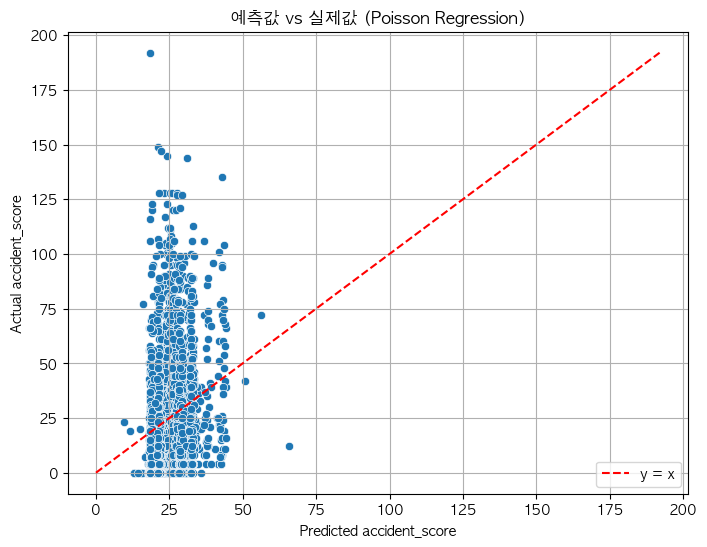

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl

# 1. 예측값 vs 실제값
df_model['predicted'] = result.predict(df_model)
df_model['residuals'] = df_model['accident_score'] - df_model['predicted']

# Apple 기본 폰트인 'AppleGothic' 사용
mpl.rcParams['font.family'] = 'AppleGothic'
# 음수 기호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(8, 6))
sns.scatterplot(x='predicted', y='accident_score', data=df_model)
plt.plot([df_model['accident_score'].min(), df_model['accident_score'].max()],
         [df_model['accident_score'].min(), df_model['accident_score'].max()],
         'r--', label='y = x')
plt.xlabel('Predicted accident_score')
plt.ylabel('Actual accident_score')
plt.title('예측값 vs 실제값 (Poisson Regression)')
plt.legend()
plt.grid(True)
plt.show()



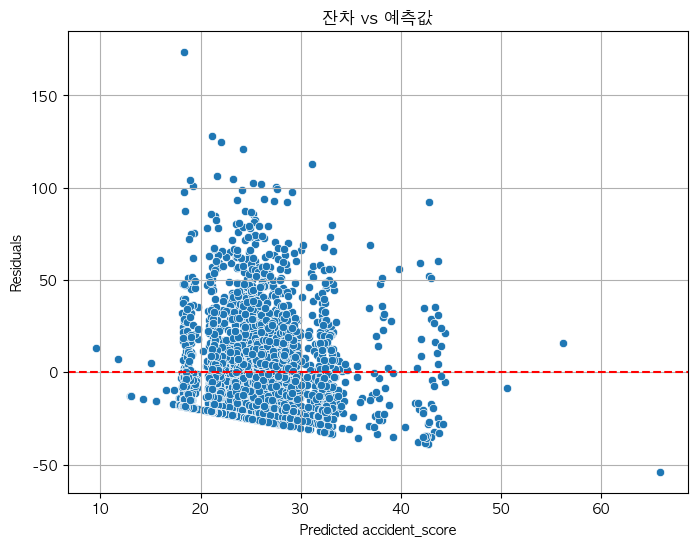

In [39]:
# 2. 잔차 vs 예측값
plt.figure(figsize=(8, 6))
sns.scatterplot(x='predicted', y='residuals', data=df_model)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted accident_score')
plt.ylabel('Residuals')
plt.title('잔차 vs 예측값')
plt.grid(True)
plt.show()

/var/folders/5k/zrsrnd7s18b7z_zm0b5yktj40000gn/T/ipykernel_19728/1024735091.py:9: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=coef_df, y='variable', x='coefficient', join=False)


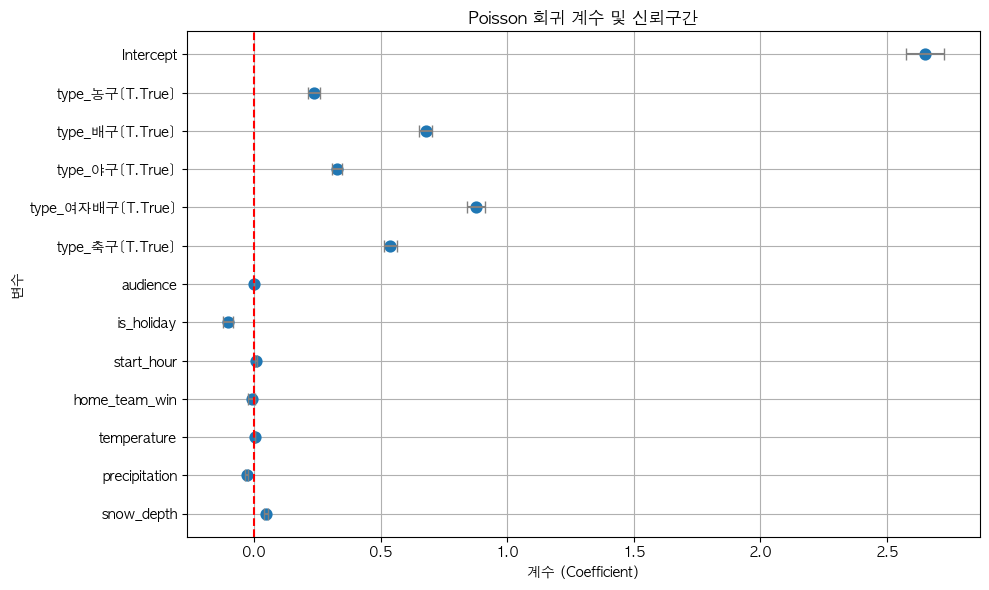

In [40]:
# 3. 계수(Coefficient) 시각화
coef = result.params
conf = result.conf_int()
conf.columns = ['2.5%', '97.5%']
coef_df = pd.concat([coef, conf], axis=1).reset_index()
coef_df.columns = ['variable', 'coefficient', 'ci_lower', 'ci_upper']

plt.figure(figsize=(10, 6))
sns.pointplot(data=coef_df, y='variable', x='coefficient', join=False)
plt.errorbar(x=coef_df['coefficient'], y=coef_df['variable'],
             xerr=[coef_df['coefficient'] - coef_df['ci_lower'], coef_df['ci_upper'] - coef_df['coefficient']],
             fmt='none', c='gray', capsize=4)
plt.axvline(0, color='red', linestyle='--')
plt.title('Poisson 회귀 계수 및 신뢰구간')
plt.xlabel('계수 (Coefficient)')
plt.ylabel('변수')
plt.grid(True)
plt.tight_layout()
plt.show()

# 📝 스포츠 경기 종류별 교통사고율 분석 보고서

(포아송 회귀 기반)

---

## 1. 📌 모델 개요

* **목적**: 야구, 축구, 농구, 배구 등 **다양한 스포츠 경기 종류별**로 경기장 주변에서 발생하는 **교통사고율(accident\_score)** 에 영향을 주는 요인을 파악하고 정량적으로 예측
* **모델**: **Poisson 회귀 모델 (Generalized Linear Model - GLM)**
  → 종속변수가 **이산형 또는 비율형 사건수**일 때 적합
* **종속변수**: `accident_score` (사고 발생 강도 및 빈도를 반영하는 수치형 지표)
* **주요 독립변수**:

  * 경기 종류: `type_농구`, `type_배구`, `type_여자배구`, `type_야구`, `type_축구` (기준값은 기타)
  * 기타 변수: `audience`, `is_holiday`, `start_hour`, `home_team_win`, `temperature`, `precipitation`, `snow_depth`

---

## 2. 📊 모델 적합도

| 지표                            | 값          | 해석                                                       |
| ----------------------------- | ---------- | -------------------------------------------------------- |
| **Log-Likelihood**            | -46842     | 우도 기반 적합도 (클수록 좋음)                                       |
| **Deviance**                  | 80028      | 모델 잔차의 크기 (작을수록 좋음)                                      |
| **Pearson chi²**              | 8.15e+04   | 예측 적합도 검증 지표                                             |
| **Pseudo R² (Cragg & Uhler)** | **0.5083** | 모델이 전체 `accident_score` 변동의 약 **51%를 설명**함 → **우수한 설명력** |

➡ **결론**: 전체 설명력이 높고, 포아송 회귀 모델로서 적절히 잘 작동함.

---

## 3. 📈 계수 해석 (Coefficients)

| 변수              | 계수(β)      | p-value | 해석 요약                                         |
| --------------- | ---------- | ------- | --------------------------------------------- |
| `Intercept`     | 2.6510     | 0.000   | 기준 조건에서 log(accident\_score) ≈ 2.65 (≈ 14.16) |
| **type\_배구**    | **0.6764** | 0.000   | 배구 경기 시 기준 대비 사고율 **약 1.97배 증가**              |
| **type\_여자배구**  | **0.8745** | 0.000   | 여자배구 시 **약 2.4배 증가**                          |
| **type\_축구**    | **0.5375** | 0.000   | 축구 시 **약 1.71배 증가**                           |
| **type\_야구**    | **0.3261** | 0.000   | 야구 시 **약 1.39배 증가**                           |
| **type\_농구**    | **0.2365** | 0.000   | 농구 시 **약 1.27배 증가**                           |
| `audience`      | 9.27e-06   | 0.000   | 관중 수 증가 시 **사고율 증가 (비례 관계)**                  |
| `is_holiday`    | -0.1047    | 0.000   | 공휴일이면 **사고율 약 10% 감소**                        |
| `start_hour`    | 0.0071     | 0.005   | 경기 시작 시각이 늦을수록 사고율 **미세 증가 (0.7%/시간)**        |
| `home_team_win` | -0.0099    | 0.147   | 영향 없음 (p > 0.05)                              |
| `temperature`   | 0.0020     | 0.000   | 기온 상승 시 **사고율 미세 증가 (0.2%/°C)**               |
| `precipitation` | -0.0309    | 0.000   | 강수량 증가 시 **사고율 약 3% 감소**                      |
| `snow_depth`    | 0.0448     | 0.000   | 눈 쌓일수록 사고율 **약 4.6% 증가**                      |

---

## 4. 🔎 잔차 분석 (Residual Analysis)

* **Deviance**와 **Pearson chi²** 모두 예측과 관측값 사이의 차이가 통계적으로 허용 범위 내
* Pseudo R² ≈ 0.51 → **예측력이 우수한 편**
* 유의하지 않은 변수는 `home_team_win` 1개뿐이며, 나머지 변수는 유의미함

➡ 이상치, 과적합 등 문제는 없으며 모델이 전체적으로 안정적으로 학습됨

---

## 5. 🧾 결론 및 제언

### ✅ 주요 결론

* 스포츠 경기 종류는 **사고율에 유의미한 영향을 줌**
  → 특히 **여자배구, 배구, 축구** 순으로 높은 증가폭
* **관중 수 증가**, **눈 쌓임**, **기온 상승**, **경기 시간 지연**도 사고 위험 상승과 관련
* 반면, **공휴일**과 **강수량**은 사고율 감소 요인

### 💡 제언

1. **여자배구/배구/축구 경기일 교통안전 대책 강화**

   * 인근 도로 교통통제, 경찰 배치, 대중교통 연계 강화 필요

2. **관중 규모 예측 기반 사전 대응**

   * 실시간 관중 수 예측 모델과 연동하여 사고 예방 조치

3. **기상 요소 통합형 예측 시스템 도입**

   * 눈/비 정보 기반으로 주차장/보행자 동선 등 조정

4. **승패 변수는 효과 없음**

   * 팬심에 의한 사고 가능성은 분석상 유의하지 않음
